In [1]:
from msmbuilder.utils import load
%pylab inline
import seaborn as sns
import msmexplorer as msme
import pandas as pd
import mdtraj as mdt
import numpy as np
import os 

Populating the interactive namespace from numpy and matplotlib


/Users/muneeb/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [144]:

class Protein(object):
    def __init__(self, loc=os.path.abspath("../full_md_mdl/")):
        self.loc = loc
        self.top = mdt.load(os.path.join(self.loc,"top.pdb"))
        self.df = load("%s/feature_descriptor.pkl"%self.loc)
        
        self.raw_feat  =load("%s/raw_features.pkl"%self.loc)
        
        self.meta_traj = mdt.load(os.path.join(self.loc,"metad_data","metad_traj.xtc"),top=self.top)
        self.feat = load("%s//featurizer.pkl"%self.loc)
        
        self.tica_mdl = load("%s/tica_mdl.pkl"%self.loc)
        self.tica_mdl.weighted_transform = False
        self.tica_mdl.commute_mapping = False
        self.tica_feat  =load("%s/tica_features.pkl"%self.loc)

        
        self.kmeans_mdl = load("%s/kmeans_mdl.pkl"%self.loc)
        self.assignments = load("%s/assignments.pkl"%self.loc)
        self.msm_mdl = load("%s/msm_mdl.pkl"%self.loc)
        if self.loc ==os.path.abspath("../full_md_mdl/"):
            self.extended_tica_data = load("%s/extended_trajs/tica_features.pkl"%loc)
            self.extended_msm = load("%s/extended_trajs/msm_mdl.pkl"%loc)
            self.extended_assignments = load("%s/extended_trajs/assignments.pkl"%loc)

In [145]:
import numpy as np
from scipy.constants import Avogadro, Boltzmann, calorie_th
from matplotlib import pyplot as pp

from corner import corner
import seaborn as sns
from seaborn.distributions import (_scipy_univariate_kde, _scipy_bivariate_kde)

from msmexplorer.utils import msme_colors

__all__ = ['plot_histogram', 'plot_free_energy']

THERMO_CONSTANT = 10**-3 * Boltzmann * Avogadro / calorie_th
def _thermo_transform(Z, temperature):
    return - THERMO_CONSTANT * temperature * np.log(Z)
@msme_colors
def plot_free_energy(data, ax=None, obs=0, temperature=300., n_samples=None,
                     pi=None, bw='scott', gridsize=30, cut=3, clip=None,
                     color='beryl', shade=True, alpha=0.5, cmap='bone',
                     vmin=None, vmax=None, n_levels=10, clabel=False,
                     clabel_kwargs=None, xlabel=None, ylabel=None,
                     labelsize=14, random_state=None,label="Regular MD"):

    #sns.set_style('whitegrid')

    if ax is None:
        ax = gca()

    if pi is not None and sum(pi) > 1:
        pi /= sum(pi)

    if isinstance(obs, int):
        obs = (obs,)

    if isinstance(random_state, (int, type(None))):
        random_state = np.random.RandomState(random_state)

    prune = data[:, obs]
    if n_samples:
        idx = random_state.choice(range(data.shape[0]), size=n_samples, p=pi)
        prune = prune[idx, :]

    if prune.shape[1] == 1:

        if clip is None:
            clip = (-np.inf, np.inf)

        X, Z = _scipy_univariate_kde(prune[:, 0], bw, gridsize, cut, clip)

        Z = _thermo_transform(Z, temperature)

        ax.plot(X, Z - Z.min(), color=color,label=label)
        
        #ax.fill_between(X, Z - Z.min(), Z.max() - Z.min(),
         #               facecolor=color, alpha=alpha)

    elif prune.shape[1] == 2:

        if clip is None:
            clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
        elif np.ndim(clip) == 1:
            clip = [clip, clip]

        X, Y, Z = _scipy_bivariate_kde(prune[:, 0], prune[:, 1], bw, gridsize,
                                       cut, clip)

        Z = _thermo_transform(Z, temperature)

        if not vmin:
            vmin = np.percentile(Z, 0)
        if not vmax:
            vmax = np.percentile(Z, 50)

        if shade:
            ax.contourf(X, Y, Z - Z.min(), cmap=pp.get_cmap(cmap),
                        levels=np.linspace(vmin, vmax, n_levels), alpha=alpha,
                        zorder=1, vmin=vmin, vmax=vmax)
        cs = ax.contour(X, Y, Z - Z.min(), cmap=pp.get_cmap('bone_r'),
                        levels=np.linspace(vmin, vmax, n_levels), alpha=1,
                        zorder=2, vmin=vmin, vmax=vmax)

        if clabel:
            if not clabel_kwargs:
                clabel_kwargs = {}

            ax.clabel(cs, **clabel_kwargs)

        ax.grid(zorder=0)

    else:
        raise ValueError('obs cannot be greater than size 2')

    if xlabel:
        ax.set_xlabel(xlabel, size=labelsize)

    if ylabel:
        ax.set_ylabel(ylabel, size=labelsize)

    return ax


In [146]:
prj = Protein()

In [147]:
partial_prj = Protein(loc="../partial_md_mdl/")

In [148]:
full_meta_traj = prj.meta_traj
partial_meta_traj = partial_prj.meta_traj

In [149]:
full_meta_traj

<mdtraj.Trajectory with 1545 frames, 22 atoms, 3 residues, and unitcells at 0x11ee7efd0>

In [150]:
partial_meta_traj

<mdtraj.Trajectory with 1623 frames, 22 atoms, 3 residues, and unitcells at 0x11b5a0cf8>

In [151]:
from msmbuilder.featurizer import DihedralFeaturizer
raw_feat = DihedralFeaturizer(sincos=False)
feat = DihedralFeaturizer()

full_raw_feat = raw_feat.transform([full_meta_traj])
full_tica_feat = prj.tica_mdl.transform(feat.transform([full_meta_traj]))


meta_raw_feat = raw_feat.transform([partial_meta_traj])
meta_tica_feat = partial_prj.tica_mdl.transform(feat.transform([partial_meta_traj]))

In [152]:
df_raw = pd.DataFrame(raw_feat.describe_features(prj.top))

In [153]:
prj.df = pd.DataFrame(DihedralFeaturizer().describe_features(prj.top))

In [154]:
sns.set_style("whitegrid")
sns.set_context("talk",1.1)

Populating the interactive namespace from numpy and matplotlib


/Users/muneeb/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(-1.5, 8)

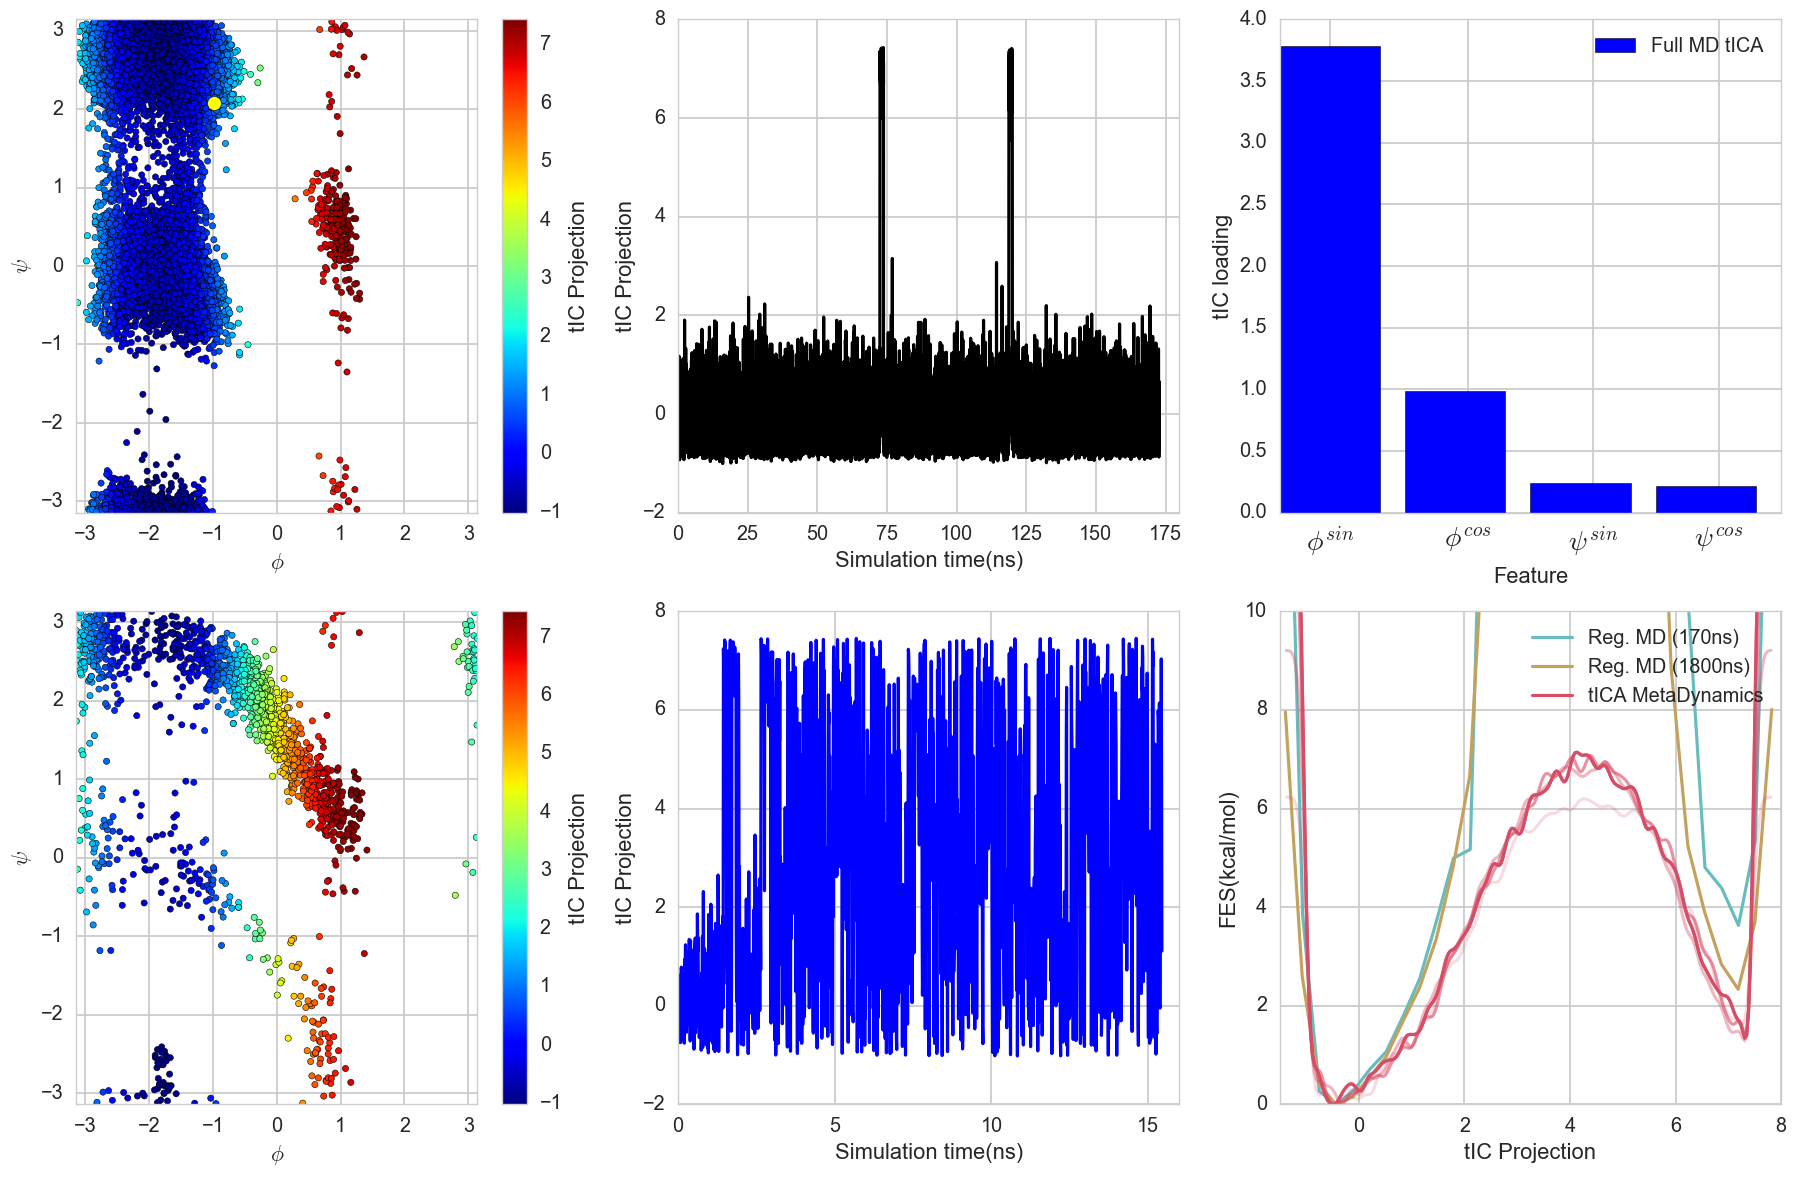

In [169]:

%pylab inline
figure(figsize=(22,14))
ax=subplot(2,3,1)
txx = np.concatenate(prj.raw_feat)
tf = np.concatenate(prj.tica_feat)
p=scatter(txx[:,0],txx[:,1],c=(tf),cmap='jet')
scatter(txx[0,0],txx[0,1],c='yellow',s=100)
xlabel(r'$\phi$')
ylabel(r'$\psi$')
xlim([-pi,pi])
ylim([-pi,pi])
cb=colorbar(p)
cb.set_label("tIC Projection")

ax=subplot(2,3,2)
plot(prj.tica_feat[0],c='black')
xticks([0,2500,5000,7500,10000,12500,15000,17500],[0,25,50,75,100,125,150,175])
ylabel("tIC Projection")
xlabel("Simulation time(ns)")

ax=subplot(2,3,3)
bar([0,1,2,3],prj.tica_mdl.components_[0,:],label="Full MD tICA")
xticks([0.4,1.5,2.5,3.5],[r'$\phi^{sin}$',r'$\phi^{cos}$',r'$\psi^{sin}$',r'$\psi^{cos}$'],size=20)
legend()
xlabel("Feature")
ylabel("tIC loading")



ax=subplot(2,3,4)
#scatter(meta_raw_feat[0][0,0],meta_raw_feat[0][0,1],s=200,c='yellow')
p=scatter(full_raw_feat[0][:,0],full_raw_feat[0][:,1],c=np.concatenate(full_tica_feat[0]),cmap='jet')
xlim([-pi,pi])
ylim([-pi,pi])
xlabel(r'$\phi$',)
ylabel(r'$\psi$')
cb=colorbar(p)
cb.set_label("tIC Projection")


ax=subplot(2,3,5)
plot(full_tica_feat[0])
xticks([0,500,1000,1500],[0,5,10,15])
ylabel("tIC Projection")
xlabel("Simulation time(ns)")


ax=subplot(2,3,6)
pop=prj.msm_mdl.populations_

pi=[]
for i in np.concatenate(prj.assignments):
    if i in prj.msm_mdl.mapping_:
        pi.append(pop[prj.msm_mdl.mapping_[i]])
    else:
        pi.append(0)
ax=plot_free_energy(np.concatenate(prj.tica_feat),ax=ax,pi=pi,shade='white',n_samples=25000,label="Reg. MD (170ns)")


pi=[]
pop = prj.extended_msm.populations_
for i in np.concatenate(prj.extended_assignments):
    if i in prj.extended_msm.mapping_:
        pi.append(pop[prj.extended_msm.mapping_[i]])
    else:
        pi.append(0)
ax=plot_free_energy(np.concatenate(prj.extended_tica_data),ax=ax,pi=pi,shade='white',n_samples=25000,\
                    label="Reg. MD (1800ns)",color='#c4a15d')


ax.legend()
ylim([0,10])
xlabel("tIC Projection")
ylabel("FES(kcal/mol)")
data = np.loadtxt("%s/metad_data/fes.dat"%prj.loc)
plot(data[:,0],data[:,1]/4.184,label="tICA MetaDynamics",c='#d64d67')
alpha_list=[0.2,0.4,0.6,0.8]
for i in range(4):
    data = np.loadtxt("%s/metad_data/fes_%d.dat"%(prj.loc,i))
    plot(data[:,0],data[:,1]/4.184,c='#d64d67',alpha=alpha_list[i])
xlabel("tIC Projection")
ylabel("FES(kcal/mol)")
ylim([0,10])
legend()
xlim([-1.5,8])

#sns.despine()

Number of cross overs is  48


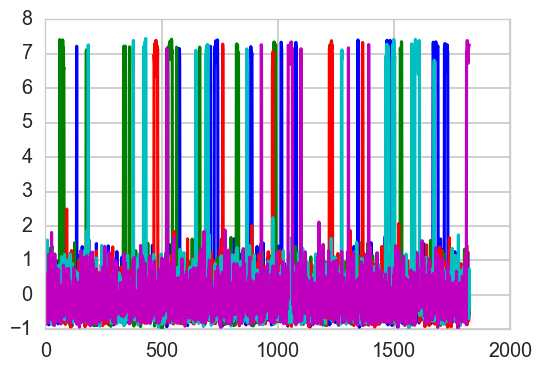

In [162]:
for i in prj.extended_tica_data:
    plot(i)
    
cross_overs=0
data=np.where(np.concatenate(prj.extended_tica_data)>5)[0]
for ind,i in enumerate(data):
    if ind==0:
        cross_overs += 1
    elif data[ind-1]==i-1:
        continue
    else:
        cross_overs +=1
print("Number of cross overs is", cross_overs)

11876
Number of cross overs is 2


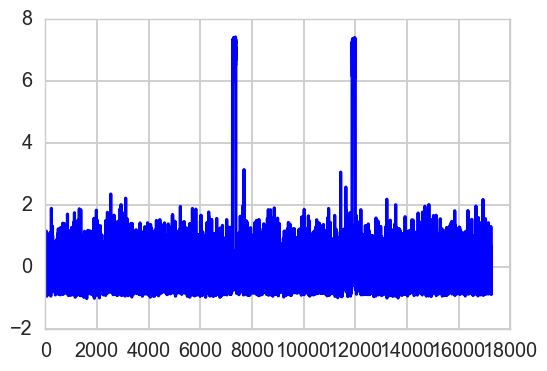

In [163]:
cross_overs=0
for i in prj.tica_feat:
    plot(i)
    
data=np.where(np.concatenate(prj.tica_feat[0])>5)[0]
for ind,i in enumerate(data):
    if ind==0:
        cross_overs += 1
        continue
    elif data[ind-1]==i-1:
        continue
    else:
        print(i)
        cross_overs +=1
print("Number of cross overs is", cross_overs)

Number of cross overs is 186


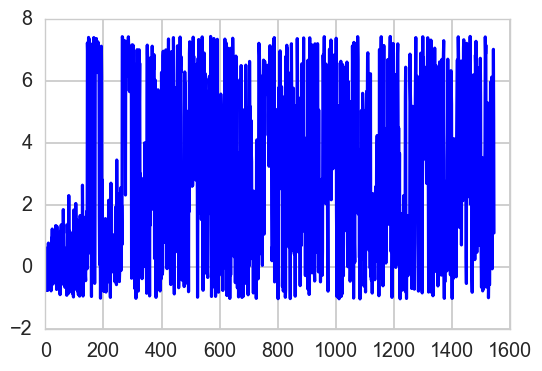

In [165]:
cross_overs=0
for i in full_tica_feat:
    plot(i)
data=np.where(np.concatenate(full_tica_feat[0])>5)[0]
for ind,i in enumerate(data):
    if ind==0:
        cross_overs += 1
    elif data[ind-1]==i-1:
        continue
    else:
        cross_overs +=1
print("Number of cross overs is", cross_overs)

Populating the interactive namespace from numpy and matplotlib


/Users/muneeb/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(-1.5, 1.5)

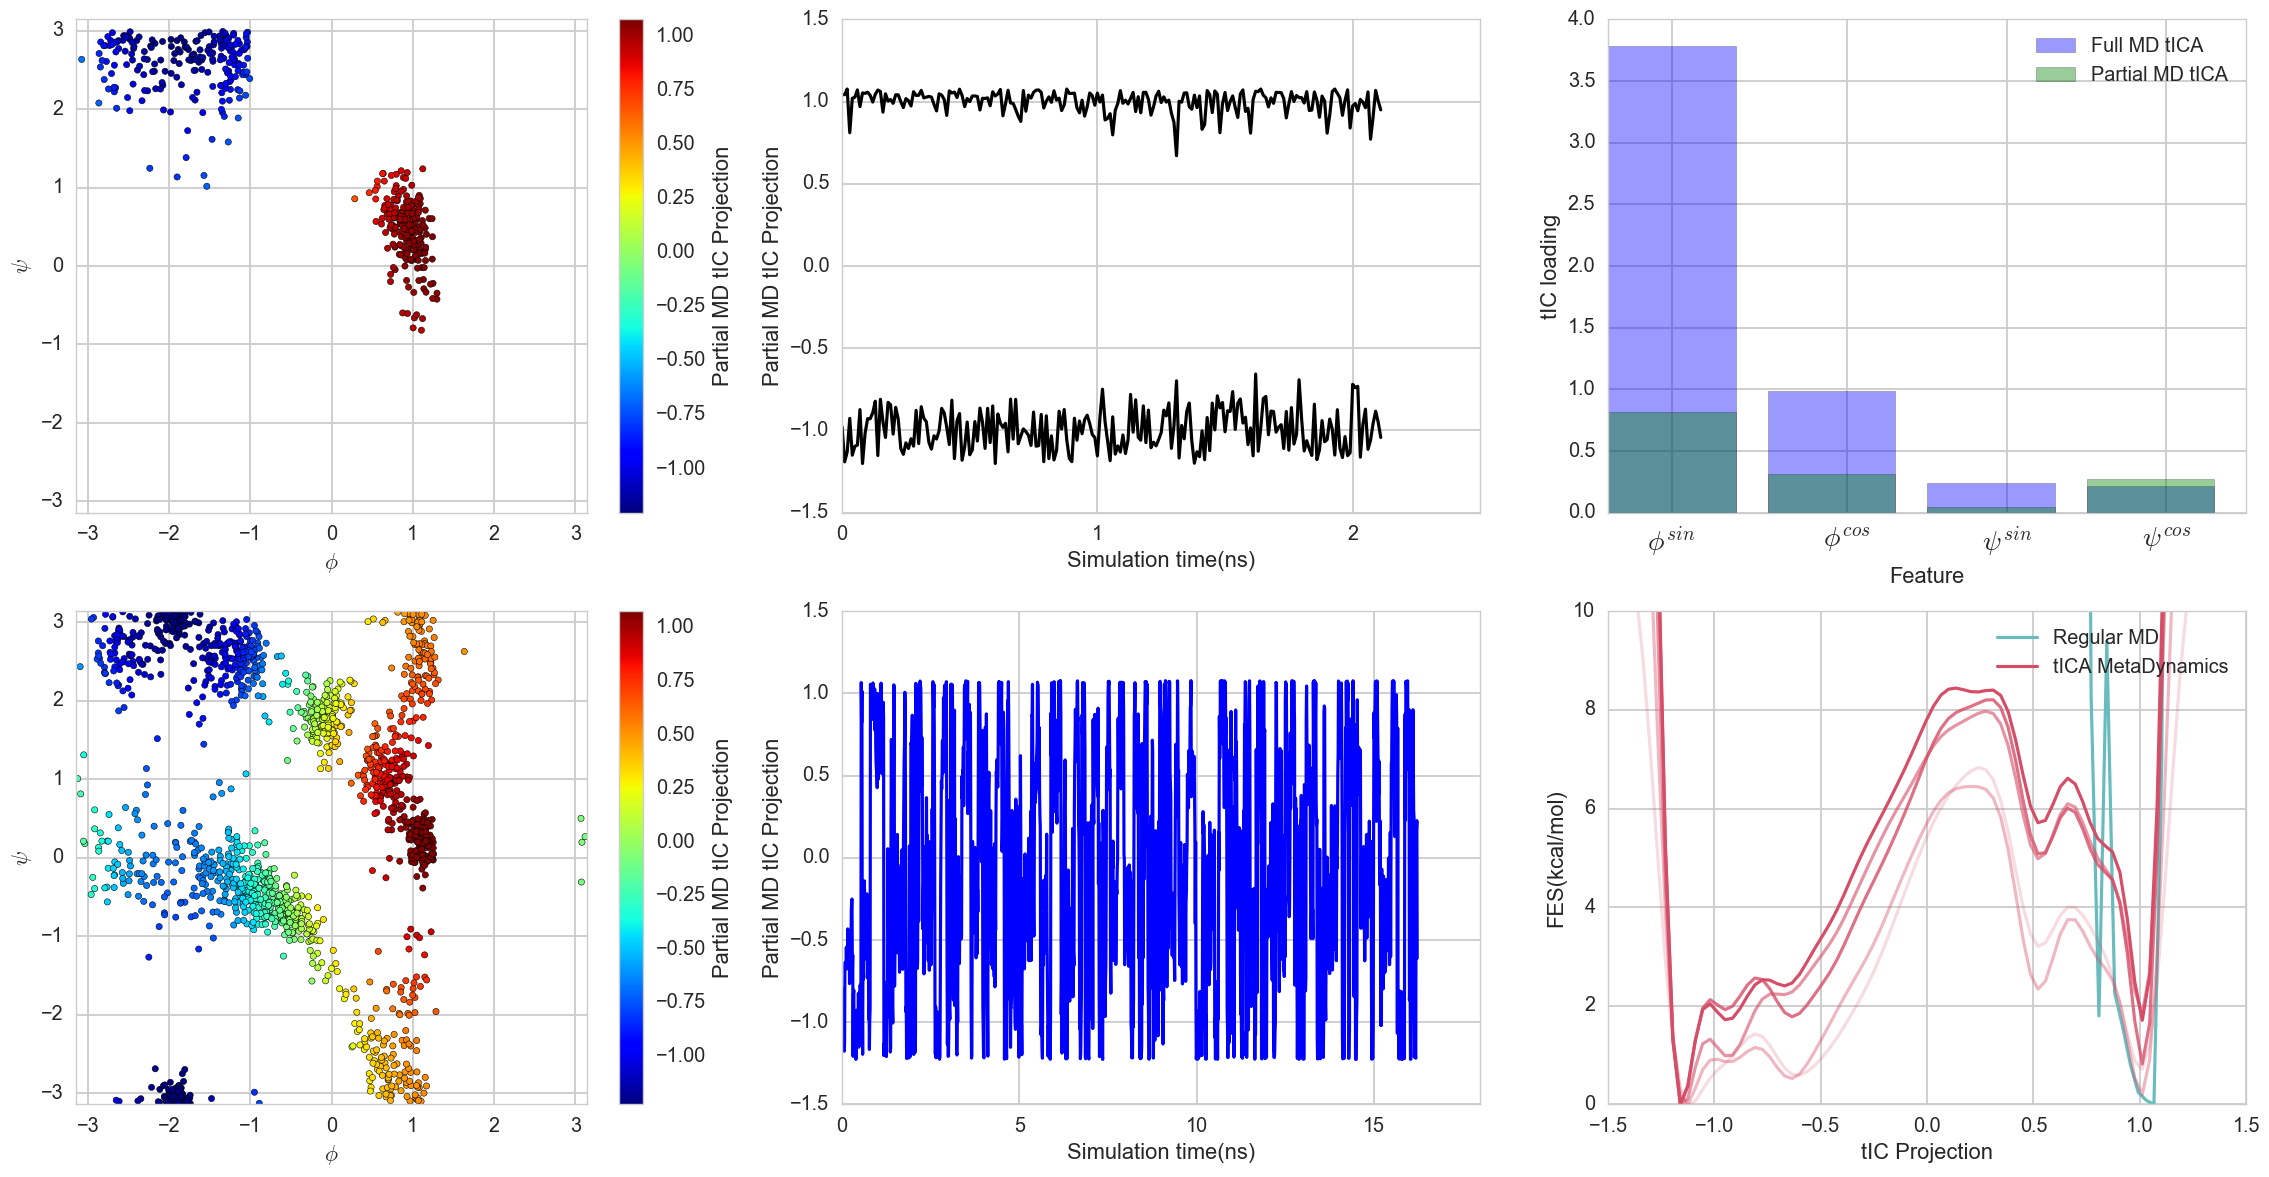

In [166]:
%pylab inline
figure(figsize=(28,14))
subplot(2,3,1)
txx = np.concatenate(partial_prj.raw_feat)
tf = np.concatenate(partial_prj.tica_feat)
p=scatter(txx[:,0],txx[:,1],c=(tf),cmap='jet')
xlabel(r'$\phi$')
ylabel(r'$\psi$')
xlim([-pi,pi])
ylim([-pi,pi])
cb=colorbar(p)
cb.set_label("Partial MD tIC Projection")


subplot(2,3,2)
plot(partial_prj.tica_feat[0],c='black')
plot(partial_prj.tica_feat[1],c='black')
xticks([0,100,200],[0,1,2])
ylabel("Partial MD tIC Projection")
xlabel("Simulation time(ns)")

subplot(2,3,3)
bar([0,1,2,3],prj.tica_mdl.components_[0,:],label="Full MD tICA",alpha=0.4)
bar([0,1,2,3],partial_prj.tica_mdl.components_[0,:],label="Partial MD tICA",color='g',alpha=0.4)
xticks([0.4,1.5,2.5,3.5],[r'$\phi^{sin}$',r'$\phi^{cos}$',r'$\psi^{sin}$',r'$\psi^{cos}$'],size=20)
legend()
xlabel("Feature")
ylabel("tIC loading")


subplot(2,3,4)
#scatter(meta_raw_feat[0][0,0],meta_raw_feat[0][0,1],s=200,c='yellow')
p=scatter(meta_raw_feat[0][:,0],meta_raw_feat[0][:,1],c=np.concatenate(meta_tica_feat[0]),cmap='jet')
xlim([-pi,pi])
ylim([-pi,pi])
xlabel(r'$\phi$',)
ylabel(r'$\psi$')
cb=colorbar(p)
cb.set_label("Partial MD tIC Projection")

subplot(2,3,5)
plot(meta_tica_feat[0])
ylabel("tIC Projection")
xticks([0,500,1000,1500],[0,5,10,15])
ylabel("Partial MD tIC Projection")
xlabel("Simulation time(ns)")


ax=subplot(2,3,6)
pop=partial_prj.msm_mdl.populations_

pi=[]
for i in np.concatenate(partial_prj.assignments):
    if i in partial_prj.msm_mdl.mapping_:
        pi.append(pop[partial_prj.msm_mdl.mapping_[i]])
    else:
        pi.append(0)
ax=plot_free_energy(np.concatenate(partial_prj.tica_feat),ax=ax,pi=pi,shade='white',n_samples=25000)

ylim([0,10])
xlabel("Partial MD tIC Projection")
ylabel("FES(kcal/mol)")
data = np.loadtxt("%s/metad_data/fes.dat"%partial_prj.loc)
plot(data[:,0],data[:,1]/4.184,label="tICA MetaDynamics",c='#d64d67')
alpha_list=[0.2,0.4,0.6,0.8]
for i in range(4):
    data = np.loadtxt("%s/metad_data/fes_%d.dat"%(partial_prj.loc,i))
    plot(data[:,0],data[:,1]/4.184,c='#d64d67',alpha=alpha_list[i])
xlabel("tIC Projection")
ylabel("FES(kcal/mol)")
ylim([0,10])
legend()
xlim([-1.5,1.5])
#sns.despine()

Number of cross overs is 122


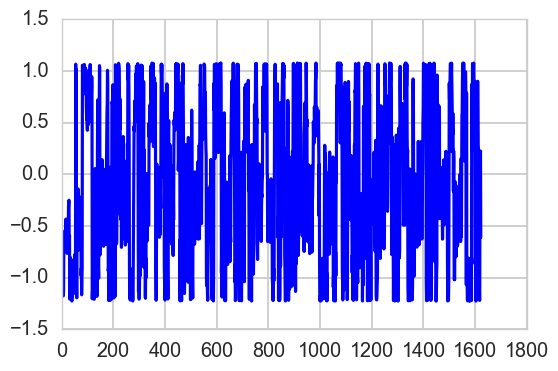

In [168]:
cross_overs=0
cross_overs=0
for i in meta_tica_feat:
    plot(i)
    
data=np.where(np.concatenate(meta_tica_feat[0])>.6)[0]
for ind,i in enumerate(data):
    if ind==0:
        cross_overs += 1
    elif data[ind-1]==i-1:
        continue
    else:
        cross_overs +=1
print("Number of cross overs is", cross_overs)

# PLUMED FILE WRITER#

In [45]:
def create_torsion_label(inds, label):
    #t: TORSION ATOMS=inds
    return "TORSION ATOMS=%s,%s,%s,%s LABEL=%s"%(inds[0],inds[1],inds[2],inds[3],label)+" \\n\\"

def create_transformer_label(dihedral_feature_label,func,offset):
    #t: TORSION ATOMS=inds
    return "MATHEVAL ARG=%s FUNC=%s(x)-%s LABEL=%s PERIODIC=NO"%(dihedral_feature_label,func,offset,func+"_"+dihedral_feature_label)+" \\n\\"

def create_mean_free_label(dihedral_feature_label, offset, label):
    return "MATHEVAL ARG=%s FUNC=%s-%s LABEL=%s PERIODIC=NO"\
%(dihedral_feature_label,dihedral_feature_label,offset,"meanfree_"+dihedral_feature_label)+" \\n\\"

In [8]:
#MDTRAJ used 0 indexing where as plumed uses 1 indexing


In [49]:
already_done_list=[]
already_done_transformed_list=[]
already_done_meanfree_list=[]

f = open("./plumed.py",'w')
f.write("plumed_script=\"RESTART "+"\\n\\"+"\n")
grid_min_list=[]
grid_max_list=[]
arg_list=[]
sigma_list=[]
height=0.2
pace=1000
for tic_index in range(1):
    
    combine_args_list=[]
    combine_coefficent_list=[]
    
    inds = np.nonzero(prj.tica_mdl.components_[tic_index,:])
    #for every feature, we need the raw dihedrals 
    for j in prj.df.iloc[inds].iterrows():
        feature_index = j[0]
        atominds = j[1]["atominds"]
        resids = j[1]["resids"]
        if len(resids)==2:
            dih_label = j[1]["featuregroup"]+"_%s_%s"%(resids[0],resids[1])
        else:
            dih_label = j[1]["featuregroup"]+"_%s"%(resids[0])
        if dih_label not in already_done_list:
            #need to add one because plumed is 1 indexed and mdtraj is not 
            output = create_torsion_label(atominds+1,label=dih_label) 
            print(output)
            f.writelines(output+"\n")
            already_done_list.append(dih_label)
    
    # now we need the sin-cos transform 
    for j in prj.df.iloc[inds].iterrows():
        feature_index = j[0]
        atominds = j[1]["atominds"]
        resids = j[1]["resids"]
        otherinfo = j[1]["otherinfo"]
        if len(resids)==2:
            dih_label = j[1]["featuregroup"]+"_%s_%s"%(resids[0],resids[1])
        else:
            dih_label = j[1]["featuregroup"]+"_%s"%(resids[0])
        output_label = otherinfo + "_" + dih_label
        if output_label not in already_done_transformed_list:
            output = create_transformer_label(dih_label, otherinfo,prj.tica_mdl.means_[feature_index])
            
            print(output)
            f.writelines(output+"\n")
            already_done_transformed_list.append(output_label)
    
    
    for j in prj.df.iloc[inds].iterrows():
        feature_index = j[0]
        residue_indices = j[1]["resids"]
        atominds = j[1]["atominds"]
        resids = j[1]["resids"]
        otherinfo = j[1]["otherinfo"]
        
        if len(resids)==2:
            dih_label = j[1]["featuregroup"]+"_%s_%s"%(resids[0],resids[1])
        else:
            dih_label = j[1]["featuregroup"]+"_%s"%(resids[0])
        
        #this is the feature label 
        feature_label = otherinfo + "_" + dih_label
        #this is the tic coefficent
        tic_coefficient = prj.tica_mdl.components_[tic_index,feature_index]
        if prj.tica_mdl.kinetic_mapping:  
            tic_coefficient *= prj.tica_mdl.eigenvalues_[tic_index]


        #tic_coefficient = a[feature_index]
        label="tic%d%d"%(tic_index,feature_index)

        combine_args_list.append(feature_label)
        combine_coefficent_list.append(str(tic_coefficient))
    output= "COMBINE LABEL=tic_%d"%tic_index+" ARG=%s"%(','.join(combine_args_list))+\
    " COEFFICIENTS=%s"%(','.join(combine_coefficent_list))+" PERIODIC=NO"+" \\n\\"
    print(output)
    f.writelines(output+"\n")
    
    
    arg_list.append("tic_%d"%tic_index)
    sigma_list.append(str(0.1))
    
output="METAD ARG=%s SIGMA=%s HEIGHT=%s FILE=HILLS PACE=%s LABEL=metad"\
      %(','.join(arg_list), ','.join(sigma_list),\
        str(height), str(pace))+" \\n\\"
print(output)
f.writelines(output+"\n")
output="PRINT ARG=%s,metad.bias STRIDE=%s FILE=COLVAR"%(','.join(arg_list), str(pace))+" \\n"
print(output)
f.writelines(output+"\""+"\n")
f.close()

TORSION ATOMS=5,7,9,15 LABEL=phi_0_1 \n\
TORSION ATOMS=7,9,15,17 LABEL=psi_1_2 \n\
MATHEVAL ARG=phi_0_1 FUNC=sin(x)--0.815241623066 LABEL=sin_phi_0_1 PERIODIC=NO \n\
MATHEVAL ARG=phi_0_1 FUNC=cos(x)--0.131125790906 LABEL=cos_phi_0_1 PERIODIC=NO \n\
MATHEVAL ARG=psi_1_2 FUNC=sin(x)-0.286726096227 LABEL=sin_psi_1_2 PERIODIC=NO \n\
MATHEVAL ARG=psi_1_2 FUNC=cos(x)--0.314836222992 LABEL=cos_psi_1_2 PERIODIC=NO \n\
COMBINE LABEL=tic_0 ARG=sin_phi_0_1,cos_phi_0_1,sin_psi_1_2,cos_psi_1_2 COEFFICIENTS=3.78464062942,0.984827650367,0.239609635308,0.21932004493 PERIODIC=NO \n\
METAD ARG=tic_0 SIGMA=0.1 HEIGHT=0.2 FILE=HILLS PACE=1000 LABEL=metad \n\
PRINT ARG=tic_0,metad.bias STRIDE=1000 FILE=COLVAR \n
